# Config

In [1]:
import pandas as pd
import geopandas as gpd # from pathlib import Path 
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches


In [2]:
# Sheets and corresponding access types
sheet_access_map = {
    'METRO - ASCENSORS A CARRER': 'Ascensor',
    'METRO - ACCÉS A PEU PLA o RAMPA': 'Peu Pla',
    'METRO - ESCALES': 'Escales'
}

# Read sheets
dfs = pd.read_excel(
    '../data/DadesTMB_REVISAT.xlsx',
    sheet_name=list(sheet_access_map.keys())
)

# Add 'accés' column based on sheet name
for sheet_name, df_sheet in dfs.items():
    df_sheet['accés'] = sheet_access_map[sheet_name]

# Concatenate
df = pd.concat(dfs.values(), ignore_index=True)

print(df.shape)
print(df.columns)


(216, 5)
Index(['NOM_ESTACIÓ', 'CODI_ACCÉS', 'NOM_ACCÉS', 'GEOMETRY', 'accés'], dtype='object')


# Process data


### Fix Inconsistencies

In [3]:
station_name_fix = {
    '126 CATALUNYA': '126 CATALUNYA (L1)',
    '212 UNIVERSITAT (L2)': '125 UNIVERSITAT (L1 i L2)',
    '319 SANTS - ESTACIÓ (L3)': '319 SANTS - ESTACIÓ (L3 i L5)',
    '319 SANTS - ESTACIÓ (L5)': '319 SANTS - ESTACIÓ (L3 i L5)',
    '533 EL COLL | LA TEIXONERA': '533 EL COLL / LA TEIXONERA',
    '1138 TORRE BARÓ VALLBONA': '1138 TORRE BARÓ I VALLBONA',
    # add the 6 problematic cases only
}
df['NOM_ESTACIÓ'] = (
    df['NOM_ESTACIÓ']
    .replace(station_name_fix)
)



### make wide

In [4]:
df_wide = (
    df
    .assign(value=True)
    .pivot_table(
        index=['CODI_ACCÉS', 'NOM_ACCÉS', 'NOM_ESTACIÓ', 'GEOMETRY'],
        columns='accés',
        values='value',
        fill_value=False
    )
    .reset_index()
)


df_wide.head()

accés,CODI_ACCÉS,NOM_ACCÉS,NOM_ESTACIÓ,GEOMETRY,Ascensor,Escales,Peu Pla
0,12001,Alcolea (escala mecànica),120 PLAÇA DE SANTS (L1),POINT (2.137076560320469 41.37545699679641),False,1.0,False
1,12101,Consell de Cent / Mercat,121 HOSTAFRANCS,POINT (2.1437090237347274 41.37551150423378),1.0,False,False
2,12111,Hostafrancs,121 HOSTAFRANCS,POINT (2.144251846264405 41.3750817184101),False,1.0,False
3,12201,Creu Coberta,122 ESPANYA (L1),POINT (2.1482912995412016 41.37526760303323),1.0,False,False
4,12202,Tarragona,122 ESPANYA (L3),POINT (2.149209902005212 41.375713915877334),False,False,1.0


In [5]:
gdf = gpd.GeoDataFrame(
    df_wide, geometry=gpd.GeoSeries.from_wkt(df_wide['GEOMETRY']), crs="EPSG:4326"
)


bool_cols = ['Ascensor', 'Escales', 'Peu Pla']
print(gdf.shape)
gdf = (
    gdf
    .groupby('CODI_ACCÉS', as_index=False)
    .agg({
        'NOM_ACCÉS': 'first',
        'NOM_ESTACIÓ': 'first',
        **{c: 'any' for c in bool_cols},
        'GEOMETRY': 'first'  # or handle separately
    })
)
gdf = gpd.GeoDataFrame(
    gdf, geometry=gpd.GeoSeries.from_wkt(gdf['GEOMETRY']), crs="EPSG:4326"
)
print(gdf.shape)
gdf.head()
type(gdf)

(169, 8)
(168, 8)


geopandas.geodataframe.GeoDataFrame

# Metrics

In [6]:
print(gdf["NOM_ESTACIÓ"].shape)
print(gdf["NOM_ESTACIÓ"].nunique())
print(gdf["CODI_ACCÉS"].nunique())

(168,)
108
168


In [7]:
# Make wide based on 
# Check for duplicated rows
duplicates = gdf[gdf["CODI_ACCÉS"].duplicated()]
print(f"Number of duplicated rows: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates)
else:
    print("No duplicated rows found.")

Number of duplicated rows: 0
No duplicated rows found.


## Standarize

In [9]:
gdf.head(1)

accés,CODI_ACCÉS,NOM_ACCÉS,NOM_ESTACIÓ,Ascensor,Escales,Peu Pla,GEOMETRY,geometry
0,12001,Alcolea (escala mecànica),120 PLAÇA DE SANTS (L1),False,True,False,POINT (2.137076560320469 41.37545699679641),POINT (2.13708 41.37546)


In [ ]:
# Add Type
gdf["Type"] = "Metro Access"

#Add Evaluation
def evaluate(row):
    if row['Ascensor']:
        return "Accessible"
    elif row['Peu Pla']:
            return "Partially accessible"
    elif row['Escales'] :
            return "Non accessible"
    else:
        return "Non accessible"

gdf.loc[:, "Evaluation"] = gdf.apply(evaluate, axis=1)

gdf["Evaluation"].value_counts()

Evaluation
Accessible              96
Non accessible          46
Partially accessible    26
Name: count, dtype: int64

# Visualize data

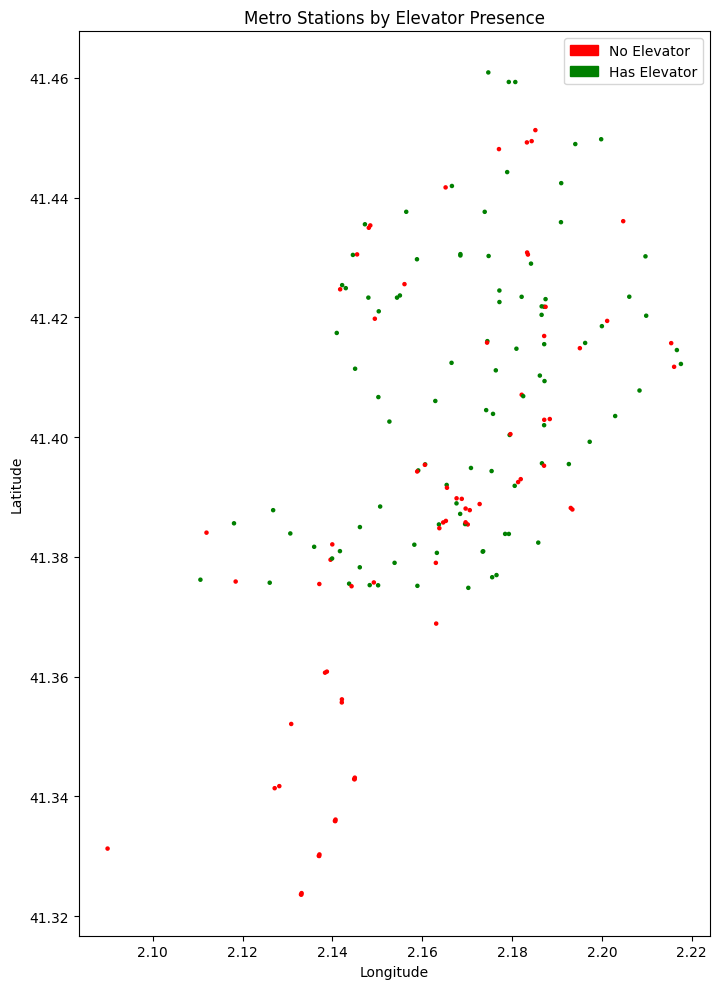

In [13]:
colors = ['green' if x else 'red' for x in gdf['Ascensor']]

ax = gdf.plot(color=colors, figsize=(12, 10), markersize=5)
red_patch = mpatches.Patch(color='red', label='No Elevator')
green_patch = mpatches.Patch(color='green', label='Has Elevator')
plt.legend(handles=[red_patch, green_patch])
plt.title('Metro Stations by Elevator Presence')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


# Save data


In [14]:
gdf.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
gdf.to_file(
    f"../data/IMPD_metro.geojson", driver='GeoJSON', index=False)
